In [1]:
import eko
import pineappl 
import numpy as np
import yaml
import pdffit
import torch
from matplotlib import pyplot as plt

plt.rcParams.update({
    #"figure.dpi": 100,               
    #"savefig.dpi": 100,             
    "figure.figsize": (10, 6),
    # 'text.usetex': True,
    # "font.family": 'Computer Modern',  
    "font.size": 15     
})

device = pdffit.device

from validphys.api import API
from validphys.fkparser import load_fktable
from validphys import convolution
from validphys.core import PDF

In [55]:
# Define the input parameters
inp = {
    "dataset_input": {"dataset": "BCDMS_NC_NOTFIXED_P_EM-F2", "variant": "legacy_dw"},  # See https://inspirehep.net/literature/276661
    "use_cuts": "internal",
    "theoryid": 40000000,
}

# Load the data using the validphys API
dataset = API.dataset(**inp)

# Covariance matrix for the SLAC data
covariance_matrix = API.covmat_from_systematics(**inp)

# NOTE: There is only one FK table for this dataset
FKTableData = load_fktable(*dataset.fkspecs).with_cuts(dataset.cuts)

xgrid = np.array(FKTableData.xgrid, dtype=np.float64)
xgrid_torch = torch.tensor(xgrid, device=device, dtype=torch.float64).detach()[:-1]
print(xgrid_torch.shape)

# NOTE: flavours are in the evolution basis
ACTIVE_FLAVOURS = FKTableData.luminosity_mapping
print(ACTIVE_FLAVOURS)

fk_array = FKTableData.get_np_fktable()
fk_array_torch = torch.tensor(fk_array, device=device, dtype=torch.float64).detach()
fk_array_torch = fk_array_torch[:, :, :-1]  # remove the last x, Q2, and flavour

fk_array_torch.shape

torch.Size([25])
[ 1  2  3  4  5  6  9 10 11]


torch.Size([333, 9, 25])

In [56]:
# NOTE: can be improved by performing the rotation to flavour basis at the end of the fit
# 
channels = pineappl.fk_table.FkTable.read(dataset.fkspecs[0].fkpath[0])._raw.channels()


In [57]:
def sort_rm(channels):
	"""
	TODO: docstring
	"""
	ev_pid = np.array(eko.basis_rotation.evol_basis_pids)
	idx = np.zeros(np.shape(channels)[0], dtype=np.int32)
	for i, item in enumerate(channels):
		idx[i] = np.sum(np.where(ev_pid == item[0], np.arange(0, np.shape(ev_pid)[0]), 0))
	return eko.basis_rotation.rotate_flavor_to_evolution[idx]


def sort_rm_new():
	"""
	TODO: docstring
	"""
	return eko.basis_rotation.rotate_flavor_to_evolution


def beta_pdf(x, b):
    """
    TODO: docstring
    """
    return torch.exp(b.log_prob(x))

def to_sigmared(fk, rotpdf):
	"""
	Forward map. Maps PDF to data space.
	
	Parameters
	----------
	fk: 
	
	rotpdf:
	
	Returns
	-------
	"""
	return (fk[:,:,:] * rotpdf).sum((1,2))

class mean_adjust:
	"""
	TODO: docstring
	"""
	def __init__(self, p_0, n = 1000):
		self.xrange = torch.linspace(1e-5, 1-1e-5, n, device=device)
		self.base = p_0
	def mean_flown_(self, f):
		return torch.mean(self.xrange*pdffit.nn.flown(self.xrange.view(-1,1), f, self.base).exp())

In [7]:
srm = torch.tensor(sort_rm(channels), device=device, dtype=torch.float64)
# srm = torch.tensor(sort_rm_new(), device=device, dtype=torch.float64)
srm.shape

torch.Size([9, 14])

#### Generation of pseudodata

In order to validate the fitting methodology we can make use of a closure test.
References: ...

##### Level 0 Closure test


Starting from some known underlying law $f_{in}$ we generate some (level 0) fakedata using our forward map 
$$
L_{0, i} = \sum_{jk} FK_{ijk}f_{\rm {in}, jk}
$$
, where $i$ indexes data-point, $j$ active flavours, and $k$ the xgrid points used in the convolution.

$f_{in}$ should be some realisation of the parametrisation that we are using, eg, if the parametrisation is $f(x) = A x^a (1-x)^b$ then $f_{in}$ could be something like $f_{in}(x; a_0, b_0) = A x^{a_0} (1-x)^{b_0} $.


In the fit we optimise something like

$$
L(f) = (L_0 - FK_{ijk}f_{jk})^TC^{-1}(L_0 - FK_{ijk}f_{jk})
$$

wrt the parameters upon which $f$ depends on. Given that theory (forward map) and data are perfectly compatible in this case, we would expect to be able to perfectly minimise the Loss function.



##### Level 1 closure test

In a level 1 closure test we can simulate real data in a more realistic way, assuming that the measured data has distribution
$$
D \sim \mathcal{N}(D_0, \Sigma)
$$
where $D_0$ is the measure instance of the data and $\Sigma$ is the covariance matrix, we can generate $L_1$ data as

$$
L_1 = L_0 + \eta, \quad \eta \sim \mathcal{N}(0, C)
$$



Definition of underlying law

[(21, 11), (103, 11), (108, 11), (115, 11), (100, 11), (203, 11), (208, 11), (215, 11), (200, 11)]


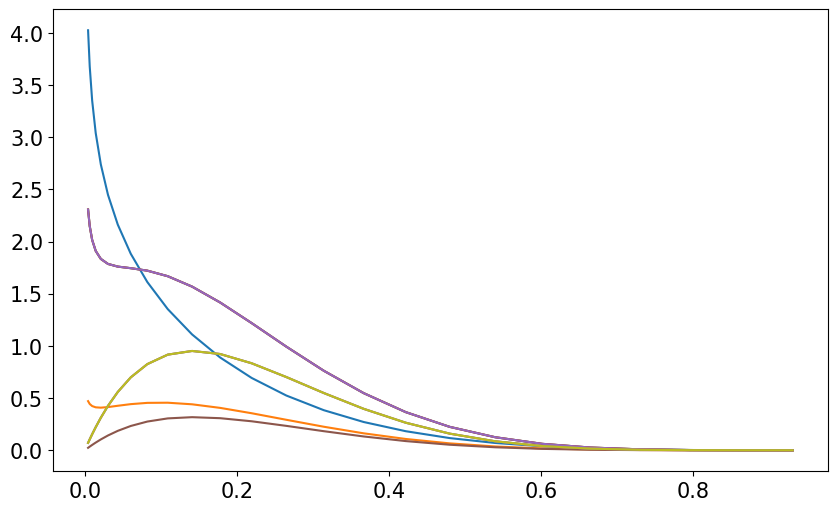

In [ ]:
beta_uv_in = torch.distributions.Beta(torch.tensor(2.0, device=device), torch.tensor(7, device=device))
beta_dv_in = torch.distributions.Beta(torch.tensor(2.0, device=device), torch.tensor(7, device=device))

beta_ub_in = torch.distributions.Beta(torch.tensor(0.8, device=device), torch.tensor(5, device=device))
beta_db_in = torch.distributions.Beta(torch.tensor(0.8, device=device), torch.tensor(5, device=device))
beta_g_in  = torch.distributions.Beta(torch.tensor(0.8, device=device), torch.tensor(5, device=device))


delta_uv   = 0.2
delta_dv   = 0.1
delta_dsea = 0.05
delta_usea = 0.075
delta_g    = 0.45

pdf_input = torch.zeros((14, xgrid_torch.shape[0]), device=device, dtype=torch.float64)

pdf_input[9] = delta_uv * beta_uv_in.log_prob(xgrid_torch).exp() + delta_usea * beta_ub_in.log_prob(xgrid_torch).exp()
pdf_input[8] = delta_dv * beta_dv_in.log_prob(xgrid_torch).exp() + delta_dsea * beta_db_in.log_prob(xgrid_torch).exp()

pdf_input[5] = delta_usea * beta_ub_in.log_prob(xgrid_torch).exp()
pdf_input[7] = delta_g * beta_g_in.log_prob(xgrid_torch).exp()
pdf_input[6] = delta_dsea * beta_db_in.log_prob(xgrid_torch).exp()

# rotate the input pdf to the evolution basis
pdf_input_ev = torch.matmul(srm, pdf_input)

fig, ax = plt.subplots()
print(channels)
for i in range(9):
    ax.plot(xgrid_torch, pdf_input_ev[i].cpu().numpy())
# ax.set_xscale('log')



In [9]:
# definition of the model

beta_uv = torch.distributions.Beta(torch.tensor(2.0, device=device), torch.tensor(7.0, device=device))
beta_ub = torch.distributions.Beta(torch.tensor(0.8, device=device), torch.tensor(5.0, device=device))
beta_dv = torch.distributions.Beta(torch.tensor(2.0, device=device), torch.tensor(7.0, device=device))
beta_db = torch.distributions.Beta(torch.tensor(0.8, device=device), torch.tensor(5.0, device=device))
beta_g  = torch.distributions.Beta(torch.tensor(0.8, device=device), torch.tensor(5.0, device=device))


delta_uv = 0.2
delta_dv = 0.1
delta_dsea = 0.05
delta_usea = 0.075
delta_g = 0.45

In [10]:
mean_flown_uv = mean_adjust(beta_uv).mean_flown_
mean_flown_uv = mean_adjust(beta_dv).mean_flown_
mom_uv = torch.tensor(0.2, device=device).detach()
mom_dv = torch.tensor(0.1, device=device).detach()

In [18]:
hidden_dim=64
in_out_dim=1

uv_net 	   = pdffit.nn.DFF_f(in_out_dim, hidden_dim, trafo="sig").to(device).to(torch.float64)
ub_net 	   = pdffit.nn.DFF_f(in_out_dim, hidden_dim, trafo="sig").to(device).to(torch.float64)
dv_net 	   = pdffit.nn.DFF_f(in_out_dim, hidden_dim, trafo="sig").to(device).to(torch.float64)
db_net 	   = pdffit.nn.DFF_f(in_out_dim, hidden_dim, trafo="sig").to(device).to(torch.float64)
g_net  	   = pdffit.nn.DFF_f(in_out_dim, hidden_dim, trafo="sig").to(device).to(torch.float64) 

uv_inv_net = pdffit.nn.DFF_g(in_out_dim, hidden_dim, trafo="sig").to(device).to(torch.float64)
ub_inv_net = pdffit.nn.DFF_g(in_out_dim, hidden_dim, trafo="sig").to(device).to(torch.float64)
dv_inv_net = pdffit.nn.DFF_g(in_out_dim, hidden_dim, trafo="sig").to(device).to(torch.float64)
db_inv_net = pdffit.nn.DFF_g(in_out_dim, hidden_dim, trafo="sig").to(device).to(torch.float64)
g_inv_net  = pdffit.nn.DFF_g(in_out_dim, hidden_dim, trafo="sig").to(device).to(torch.float64) 

params = list(uv_net.parameters()) + list(ub_net.parameters()) + list(dv_net.parameters()) + list(db_net.parameters()) + list(g_net.parameters()) + list(
          uv_inv_net.parameters()) + list(ub_inv_net.parameters()) + list(dv_inv_net.parameters()) + list(db_inv_net.parameters()) + list(g_inv_net.parameters())

In [20]:
# Generation of L0 data
L0_data = to_sigmared(fk_array_torch, pdf_input_ev)

torch.Size([9, 25])


In [48]:
opt = torch.optim.NAdam(params, lr=1e-5)

mse = torch.nn.MSELoss()

Cinv = torch.tensor(np.linalg.inv(covariance_matrix), dtype=torch.float64)

def chi2_loss(d, t, Cinv):
    """
    TODO: ...
    """
    return (d-t).T @ (Cinv) @ (d-t)


In [49]:
uv_flown = pdffit.nn.flown(xgrid_torch.view(-1,1), uv_net, beta_uv).exp()

In [50]:
debug_ = 0

for itr in range(10000):
	opt.zero_grad()

	uv_flown = pdffit.nn.flown(xgrid_torch.view(-1,1), uv_net, beta_uv).exp()
	ub_flown = pdffit.nn.flown(xgrid_torch.view(-1,1), ub_net, beta_ub).exp()
	dv_flown = pdffit.nn.flown(xgrid_torch.view(-1,1), dv_net, beta_dv).exp()
	db_flown = pdffit.nn.flown(xgrid_torch.view(-1,1), db_net, beta_db).exp()
	g_flown  = pdffit.nn.flown(xgrid_torch.view(-1,1), g_net , beta_g).exp()

	pdf_m = torch.zeros((14, uv_flown.shape[0]), device=device, dtype=torch.float64)

	pdf_m[9] = delta_uv * uv_flown.view(-1) + delta_usea * ub_flown.view(-1)
	pdf_m[5] = delta_usea * ub_flown.view(-1) #/xgrid_torch.view(1,-1)
	pdf_m[7] = delta_g * g_flown.view(-1) #/xgrid_torch.view(1,-1)
	pdf_m[8] = delta_dv * dv_flown.view(-1) + delta_dsea*db_flown.view(-1)
	pdf_m[6] = delta_dsea * db_flown.view(-1)  #/xgrid_torch.view(1,-1)

	rot_pdf = torch.matmul(srm.detach(), pdf_m)

	loss_mean = 0 # mse(mean_flown_uv(uv_net), mom_uv) + mse(mean_flown_uv(dv_net), mom_dv)
	loss_sigma = chi2_loss(to_sigmared(fk_array_torch, rot_pdf), L0_data, Cinv)
	
	# loss_sigma = mse(to_sigmared(fk_array_torch, rot_pdf), L0_data)

	loss = loss_sigma + loss_mean
	loss.backward()
	opt.step()

	if itr % 250 == 0:
		# debug = to_sigmared(fkm, rot_pdf)
		# debug_ = uv_net(xgrid_torch)
		print(itr, " ", loss.item())

0   0.6060413987751218
250   0.6034179396034776
500   0.6031560890976038
750   0.59820134100934
1000   0.5955280824835573
1250   0.5927121066192829
1500   0.5903607601928228
1750   0.5901686160528502
2000   0.5877979241805079
2250   0.581209454050158
2500   0.5777809726668939
2750   0.5766346736347117
3000   0.5723190900712596
3250   0.567799981505245
3500   0.5652405195223046
3750   0.5623048548396952
4000   0.557627201399532
4250   0.5541846594711951
4500   0.5512818999430311
4750   0.5471440971420619
5000   0.543292098634521
5250   0.5399696559709546
5500   0.536336064632857
5750   0.5323864456808101
6000   0.5286606977000243
6250   0.5251167673295152
6500   0.5213734854033087
6750   0.5173996037895077
7000   0.5135620126837863
7250   0.5099930764586735
7500   0.5063548505763588
7750   0.502452757970906
8000   0.4985387546818512
8250   0.49486393540895524
8500   0.4913588073941827
8750   0.4876794988873958
9000   0.48383660245084686
9250   0.48000246944858127
9500   0.47632134888430

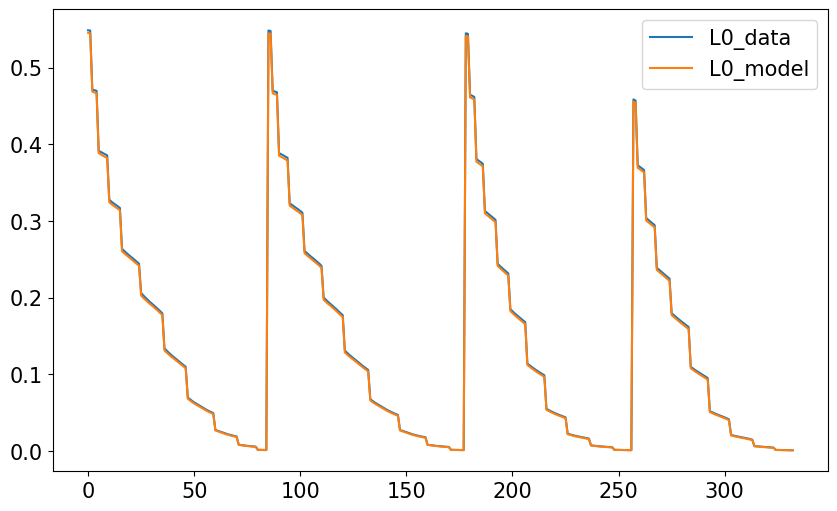

In [51]:
fig, ax = plt.subplots()

ax.plot(L0_data, label="L0_data")
ax.plot(to_sigmared(fk_array_torch, rot_pdf).detach().numpy(), label="L0_model")

ax.legend()

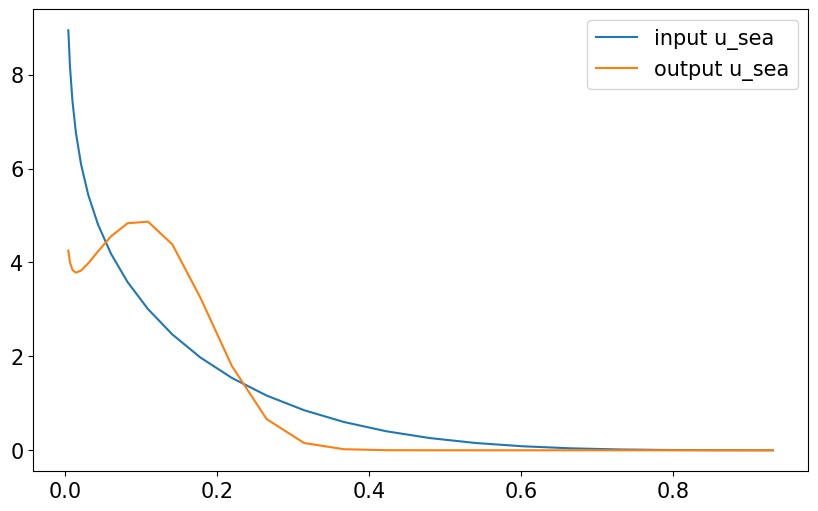

In [54]:
fig, ax = plt.subplots()

# ax.plot(xgrid_torch, pdf_input[7] / delta_g, label="input g")
ax.plot(xgrid_torch, pdf_input[5] / delta_usea, label="input u_sea")

# ax.plot(xgrid_torch, pdffit.nn.flown(xgrid_torch.view(-1,1), g_net , beta_g).exp().detach().numpy(), label="output g")
ax.plot(xgrid_torch, pdffit.nn.flown(xgrid_torch.view(-1,1), ub_net , beta_ub).exp().detach().numpy(), label="output u_sea")

ax.legend()

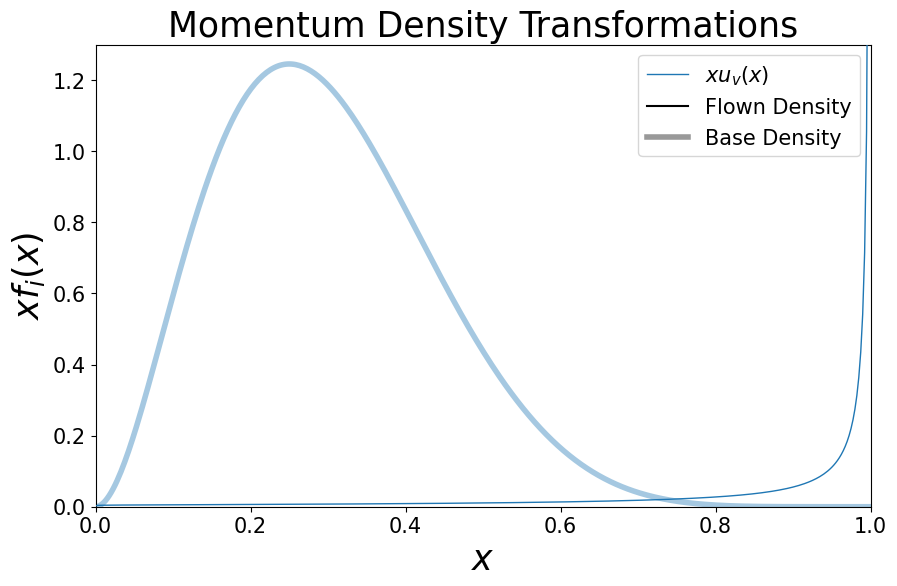

In [84]:
plt.ylim(0, 1.3)
plt.xlim(0, 1)
bounds = (1e-4, 1-1e-4)

pdffit.plot_densities(uv_net, uv_inv_net, beta_uv, beta_uv, tb_disp=(False, True), fi_disp=(True, False), fac="momentum_u", bounds = bounds, fcolor="C0", bcolor="C0", balpha=0.4, blabel=None, flabel=r'$x u_v(x)$'         )

# pdffit.plot_densities(ub_net, ub_inv_net, beta_ub, beta_ub, tb_disp=(False, True), fi_disp=(True, False), fac=delta_usea  , bounds = bounds, fcolor="C1", bcolor="C1", balpha=0.4, blabel=None, flabel=r'$x d_v(x)$'         )
# pdffit.plot_densities(dv_net, dv_inv_net, beta_dv, beta_dv, tb_disp=(False, True), fi_disp=(True, False), fac="momentum"  , bounds = bounds, fcolor="C3", bcolor="C3", balpha=0.4, blabel=None, flabel=r'$x u_s(x)$'         )
# pdffit.plot_densities(db_net, db_inv_net, beta_db, beta_db, tb_disp=(False, True), fi_disp=(True, False), fac=delta_dsea  , bounds = bounds, fcolor="C2", bcolor="C2", balpha=0.4, blabel=None, flabel=r'$x d_s(x)$'         )
# pdffit.plot_densities(g_net , g_inv_net , beta_g , beta_g , tb_disp=(False, True), fi_disp=(True, False), fac=delta_g     , bounds = bounds, fcolor="C4", bcolor="C4", balpha=0.4, blabel=None, flabel=r'$x (g_v(x)+g_s(x))$')

plt.plot(0,0, "k", label="Flown Density")
#plt.plot(0,0, "k", ls="--", alpha=0.4, label="Mean Adjusted")
plt.plot(0,0, "k", lw=4, alpha=0.4, label="Base Density")

plt.title("Momentum Density Transformations", fontsize=25)
plt.ylabel(r"$x f_i(x)$", fontsize=25)
plt.xlabel(r"$x$", fontsize=25)
plt.legend(fontsize=15)


In [ ]:
import importlib
importlib.reload(pdffit.viz.plot_utils)
importlib.reload(pdffit.nn)
importlib.reload(pdffit)

In [18]:
torch.tensor([delta_uv  ,delta_usea,delta_dv  ,delta_dsea,delta_g]).sum()

tensor(0.8750)